In [1]:
!pip install  -q transformers
!pip install  -q pytorch-lightning
!pip install  -q einops
!pip install  -q tqdm
!pip install  -q 'Pillow==7.1.2'
!pip install  -q datasets
!pip install -q wandb
!pip install -q evaluate seqeval

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pytesseract 0.3.10 requires Pillow>=8.0.0, but you have pillow 7.1.2 which is incompatible.
imageio 2.19.3 requires pillow>=8.3.2, but you have pillow 7.1.2 which is incompatible.


In [2]:
## Logging into wandb

import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api")
wandb.login(key=secret_value_0)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
## Cloning the repository
!git clone https://github.com/uakarsh/docformer.git

Cloning into 'docformer'...
remote: Enumerating objects: 1304, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (202/202), done.
remote: Total 1304 (delta 184), reused 46 (delta 44), pack-reused 1050
Receiving objects: 100% (1304/1304), 4.37 MiB | 7.24 MiB/s, done.
Resolving deltas: 100% (699/699), done.


In [4]:
## Importing the libraries

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

import torch.nn.functional as F
import torchvision.models as models
from torchvision.transforms import ToTensor

## Adding the path of docformer to system path
import sys
sys.path.append('./docformer/src/docformer/')

## Importing the functions from the DocFormer Repo
from dataset import resize_align_bbox, get_centroid, get_pad_token_id_start_index, get_relative_distance
from modeling import DocFormerEncoder,ResNetFeatureExtractor,DocFormerEmbeddings,LanguageFeatureExtractor
from transformers import BertTokenizerFast

from datasets import load_dataset
import evaluate

In [5]:
import pytorch_lightning as pl
pl.seed_everything(42, workers=True)

42

## Preparing the dataset

In [6]:
## Dataset loading part
dataset = load_dataset("nielsr/funsd-layoutlmv3")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset funsd downloaded and prepared to /root/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/0e3f4efdfd59aa1c3b4952c517894f7b1fc4d75c12ef01bcc8626a69e41c1bb9. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
def get_tokens_with_boxes(unnormalized_word_boxes, word_ids, tokens,max_seq_len = 512, pad_token_box = [0, 0, 0, 0], pad_token_class = -100):

    # assert len(unnormalized_word_boxes) == len(word_ids), this should not be applied, since word_ids may have higher 
    # length and the bbox corresponding to them may not exist

    unnormalized_token_boxes = []
    final_token_label = []
    
    i = 0
    for word_idx, token in zip(word_ids, tokens):
        if word_idx is None:
            break
        unnormalized_token_boxes.append(unnormalized_word_boxes[word_idx])
        final_token_label.append(token)
        i+=1

    # all remaining are padding tokens so why add them in a loop one by one
    num_pad_tokens = len(word_ids) - i - 1
    if num_pad_tokens > 0:
        unnormalized_token_boxes.extend([pad_token_box] * num_pad_tokens)
        final_token_label.extend([pad_token_class] * num_pad_tokens)


    if len(unnormalized_token_boxes)<max_seq_len:
        unnormalized_token_boxes.extend([pad_token_box] * (max_seq_len-len(unnormalized_token_boxes)))
        final_token_label.extend([pad_token_class] * (max_seq_len-len(final_token_label)))

    return unnormalized_token_boxes, final_token_label

In [8]:
def create_features_for_token_cls(image,
        labels,
        tokenizer = tokenizer,
        target_size=(500,384),  # This was the resolution used by the authors
        max_seq_length=512,
        bounding_box = None,
        words = None):
    
    
    CLS_TOKEN_BOX = [0, 0, 1000, 1000]    # Can be variable, but as per the paper, they have mentioned that it covers the whole image
    # step 2: resize image
    resized_image = image.resize(target_size)
    
    # step 4: tokenize words and get their bounding boxes (one word may split into multiple tokens)
    encoding = tokenizer(words,
                         padding="max_length",
                         max_length=max_seq_length,
                         is_split_into_words=True,
                         truncation=True,
                         add_special_tokens=False)
    
    unnormalized_token_boxes, final_token_label = get_tokens_with_boxes(unnormalized_word_boxes = bounding_box,
                                                     tokens = labels,
                                                     word_ids = encoding.word_ids())
    
    # step 5: add special tokens and truncate seq. to maximum length
    unnormalized_token_boxes = [CLS_TOKEN_BOX] + unnormalized_token_boxes[:-1]
    final_token_label = [-100] + final_token_label[:-1]
    # add CLS token manually to avoid autom. addition of SEP too (as in the paper)
    encoding["input_ids"] = [tokenizer.cls_token_id] + encoding["input_ids"][:-1]
    
    # step 6: Add bounding boxes to the encoding dict
    encoding["unnormalized_token_boxes"] = unnormalized_token_boxes
    
    # step 8: normalize the image
    encoding["resized_scaled_img"] = ToTensor()(resized_image)
    
    # step 10: rescale and align the bounding boxes to match the resized image size (typically 224x224)
    resized_and_aligned_bboxes = []

    for bbox in unnormalized_token_boxes:
        # performing the normalization of the bounding box
        resized_and_aligned_bboxes.append(resize_align_bbox(tuple(bbox), 1000, 1000, *target_size)) ## The bbox are resized to (1000, 1000)

    encoding["resized_and_aligned_bounding_boxes"] = resized_and_aligned_bboxes
    encoding['token_class'] = final_token_label

    # step 11: add the relative distances in the normalized grid
    bboxes_centroids = get_centroid(resized_and_aligned_bboxes)
    pad_token_start_index = get_pad_token_id_start_index(words, encoding, tokenizer)
    a_rel_x, a_rel_y = get_relative_distance(resized_and_aligned_bboxes, bboxes_centroids, pad_token_start_index)

    # step 12: convert all to tensors
    for k, v in encoding.items():
        encoding[k] = torch.as_tensor(encoding[k])

    encoding.update({
        "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
        "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),
        })

    
    # step 16: keys to keep, resized_and_aligned_bounding_boxes have been added for the purpose to test if the bounding boxes are drawn correctly or not, it maybe removed
    keys = ['resized_scaled_img', 'x_features','y_features','input_ids','resized_and_aligned_bounding_boxes', 'token_class']

    final_encoding = {k:encoding[k].tolist() for k in keys}

    del encoding
    return final_encoding

In [9]:
def prepare_examples(sample):
  final_encoding = create_features_for_token_cls(image = sample['image'],
                                              bounding_box = sample['bboxes'],
                                              words = sample['tokens'],
                                              labels = sample['ner_tags'])

  return final_encoding

In [10]:
column_names = list(dataset['train'].features.keys())

In [11]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'resized_scaled_img': Array3D(dtype="float32", shape=(3, 384, 500)),
    'x_features': Array2D(dtype="int64", shape=(512, 8)),
    'y_features': Array2D(dtype="int64", shape=(512, 8)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'resized_and_aligned_bounding_boxes': Array2D(dtype="int64", shape=(512, 4)),
    'token_class' : Sequence(feature=Value(dtype='int64'))
})

train_dataset = dataset["train"].map(
    prepare_examples,
    remove_columns=column_names,
    batched=False,
    features=features
)

eval_dataset = dataset["test"].map(
    prepare_examples,
    remove_columns=column_names, 
    batched=False,
    features=features
)

  0%|          | 0/149 [00:00<?, ?ex/s]

  0%|          | 0/50 [00:00<?, ?ex/s]

In [12]:
columns = list(train_dataset[0].keys())

In [13]:
train_dataset.set_format(type='torch', columns= columns)
eval_dataset.set_format(type='torch', columns=columns)

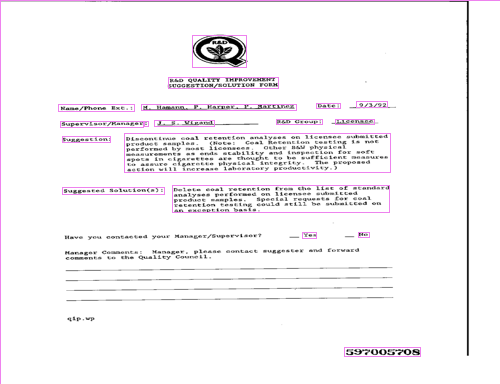

In [14]:
sample = train_dataset[0]

image = sample['resized_scaled_img']
x_features = sample['x_features']
y_features = sample['y_features']
input_ids = sample['input_ids']
resized_and_aligned_bounding_boxes = sample['resized_and_aligned_bounding_boxes']
token_class = sample['token_class']

from torchvision import transforms
from PIL import Image, ImageDraw


image = transforms.ToPILImage()(torch.tensor(image))
# create rectangle image
draw_on_img = ImageDraw.Draw(image)  

for box in resized_and_aligned_bounding_boxes.tolist():
  draw_on_img.rectangle(box, outline ="violet")

image

In [15]:
def collate_fn(data_bunch):

  '''
  A function for the dataloader to return a batch dict of given keys

  data_bunch: List of dictionary
  '''

  dict_data_bunch = {}

  for i in data_bunch:
    for (key, value) in i.items():
      if key not in dict_data_bunch:
        dict_data_bunch[key] = []
      dict_data_bunch[key].append(value)

  for key in list(dict_data_bunch.keys()):
      dict_data_bunch[key] = torch.stack(dict_data_bunch[key], axis = 0)

  return dict_data_bunch

In [16]:
class DataModule(pl.LightningDataModule):

  def __init__(self, batch_size:int = 2):
    super(DataModule, self).__init__()
    self.batch_size = batch_size

  def train_dataloader(self):
    return DataLoader(train_dataset, batch_size = self.batch_size,
                      shuffle = True)
    
  def val_dataloader(self):
    return DataLoader(eval_dataset, batch_size = self.batch_size,
                      shuffle = False)

In [17]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
    
num_labels = len(label_list)

In [18]:
def get_labels(predictions, references):

    # Transform predictions and references tensors to numpy arrays
    if predictions.device.type == "cpu":
        y_pred = predictions.detach().clone().numpy()
        y_true = references.detach().clone().numpy()

    else:
        y_pred = predictions.detach().cpu().clone().numpy()
        y_true = references.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens)
    true_predictions = [
        [labels[p] for (p, l) in zip(pred, gold_label) if l != -100]
        for pred, gold_label in zip(y_pred, y_true)
    ]
    true_labels = [
        [labels[l] for (p, l) in zip(pred, gold_label) if l != -100]
        for pred, gold_label in zip(y_pred, y_true)
    ]
    return true_predictions, true_labels

In [19]:
labels = dataset["train"].features['ner_tags'].feature.names

## Modeling:

In [20]:
class PL_Model(pl.LightningModule):

  def __init__(self, config, model_name = 'docformer-base', lr = 5e-5):

    super(PL_Model, self).__init__()
    self.save_hyperparameters()
    self.resnet = ResNetFeatureExtractor()
    self.embeddings = DocFormerEmbeddings(config)
    self.lang_emb = LanguageFeatureExtractor()
    self.config = config
    self.dropout = nn.Dropout(config['hidden_dropout_prob'])
    self.linear_layer = nn.Linear(in_features = config['hidden_size'], out_features = config['classes'])
    self.encoder = DocFormerEncoder(config)

    ## Metrics
    self.train_metric = evaluate.load("seqeval")
    self.val_metric = evaluate.load("seqeval")

    ## Parameters
    self.lr = lr
  
  def forward(self, batch_dict):
    x_feat = batch_dict['x_features']
    y_feat = batch_dict['y_features']

    token = batch_dict['input_ids']
    img = batch_dict['resized_scaled_img']

    v_bar_s, t_bar_s = self.embeddings(x_feat,y_feat)
    v_bar = self.resnet(img)
    t_bar = self.lang_emb(token)
    out = self.encoder(t_bar,v_bar,t_bar_s,v_bar_s)
    out = self.linear_layer(out)
    return out

  def configure_optimizers(self):
    return torch.optim.AdamW(self.parameters(), lr = self.hparams['lr'])

  def training_step(self, batch, batch_idx):

    ## Forward Propagatipn
    outputs = self.forward(batch)
    loss = F.cross_entropy(outputs.transpose(1, 2), batch["token_class"], ignore_index = -100)
    ## Predictions and adding the metrics
    predictions = outputs.argmax(-1)
    true_predictions, true_labels = get_labels(predictions, batch["token_class"])
    self.train_metric.add_batch(references=true_labels, predictions=true_predictions)

    ## Logging Purpose
    results = self.train_metric.compute()
    self.log("train_loss", loss.item(), prog_bar = True)
    self.log("train_overall_fl", results["overall_f1"], prog_bar = True)
    self.log("train_overall_recall", results["overall_recall"], prog_bar = True)
    self.log("train_overall_precision", results["overall_precision"], prog_bar = True)

    ## Backpropagation
    return loss

  def validation_step(self, batch, batch_idx):

    outputs = self.forward(batch)
    loss = F.cross_entropy(outputs.transpose(1, 2), batch["token_class"], ignore_index = -100)
    
    predictions = outputs.argmax(-1)
    true_predictions, true_labels = get_labels(predictions, batch["token_class"])
    self.val_metric.add_batch(references=true_labels, predictions=true_predictions)

    ## Logging Purpose
    results = self.val_metric.compute()
    self.log("val_loss", loss.item(), prog_bar = True)
    self.log("val_overall_fl", results["overall_f1"], prog_bar = True)
    self.log("val_overall_recall", results["overall_recall"], prog_bar = True)
    self.log("val_overall_precision", results["overall_precision"], prog_bar = True)
    
    return loss

In [21]:
config = {
  "coordinate_size": 96,              ## (768/8), 8 for each of the 8 coordinates of x, y
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "image_feature_pool_shape": [7, 7, 256],
  "intermediate_ff_size_factor": 4,
  "max_2d_position_embeddings": 1024,
  "max_position_embeddings": 512,
  "max_relative_positions": 8,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "shape_size": 96,
  "vocab_size": 30522,
  "layer_norm_eps": 1e-12,
  "classes": 7
}

In [22]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

def main():
    
    checkpoint_callback = ModelCheckpoint(
        dirpath="./docformer/models", monitor="val_loss", mode="min", filename = 'docformer_best_ckpt'
    )
    
    wandb.init(config = config, project="DocFormer on FUNSD")
    wandb_logger = WandbLogger(project="DocFormer on FUNSD", entity="iakarshu")
    
    max_epochs = 100
    trainer = pl.Trainer(
        max_epochs = max_epochs,
        default_root_dir="./docformer/logs",
        accelerator="auto", 
        devices="auto",
        logger=wandb_logger,
        callbacks=[checkpoint_callback]
    )
    
    pl_model = PL_Model(config)
    pl_dl = DataModule()
    
    trainer.fit(pl_model, pl_dl)

    return pl_model, pl_dl

In [23]:
if __name__ == "__main__":
  pl_model, pl_dl = main()

wandb: Currently logged in as: iakarshu. Use `wandb login --relogin` to force relogin


Downloading:   0%|          | 0.00/606 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/432M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [24]:
import os
model_path = os.path.join('./docformer/models', os.listdir('./docformer/models')[0])
pl_model = pl_model.load_from_checkpoint(model_path)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

In [25]:
from tqdm.auto import tqdm

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
eval_metric = evaluate.load("seqeval")
pl_model.eval();

model = pl_model.to(device)

for idx, batch in enumerate(tqdm(pl_dl.val_dataloader())):
    # move batch to device
    batch = {k:v.to(device) for k,v in batch.items()}
    with torch.no_grad():
      outputs = model.forward(batch)

    predictions = outputs.argmax(-1)
    true_predictions, true_labels = get_labels(predictions, batch["token_class"])
    eval_metric.add_batch(references=true_labels, predictions=true_predictions)

  0%|          | 0/25 [00:00<?, ?it/s]

In [27]:
results = eval_metric.compute()

In [28]:
for key in ['overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy']:
  print_statement = '{0: <30}'.format(str(key) + " has value:")
  print(print_statement, results[key])

overall_precision has value:   0.1101414384592236
overall_recall has value:      0.1831831831831832
overall_f1 has value:          0.13756812629205037
overall_accuracy has value:    0.3203169863328357
